In [809]:
import pandas as pd
import seaborn as sns
import random
import itertools
import math
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
from mpl_toolkits.axes_grid1 import AxesGrid
from numpy import ma
%matplotlib inline

# Interaction network experiments

The following code generates a simple population, calculates interactions within this population under various selection schemes, and plots the resulting network.

In [812]:
# Create population

POP_SIZE = 10

GENOME_LENGTH = 5


pop = []
for _ in range(POP_SIZE):
    # Geometric distribution makes it rare to be particularly good at an axis, to simulate
    # a population occupying a diversity of niches (as you would expect to evolve under
    # these selection schemes)
    pop.append(tuple([np.random.geometric(.5) for i in range(GENOME_LENGTH)]))


In [813]:
def lexicase_fitness(orgs):
    """
    Calculate the biological fitness of each org in orgs (a list of lists of ints, 
    where each inner list is an org) under lexicase selection.
    
    Returns - a dictionary mapping orgs (lists of ints) to fitnesses
    """
    fitnesses = {org:0.0 for org in orgs}

    # Iterate over all possible orderings of fitness functions
    # and count up the number that each org wins
    for order in itertools.permutations(range(len(orgs[0]))): 
        remaining = orgs[:]
        
        # Find best individuals for each axis
        for axis in order:
            best = 0
            winners = []
            for i in range(len(remaining)):
                if remaining[i][axis] > remaining[best][axis]:
                    best = i
                    winners = [remaining[i]]
                elif remaining[i][axis] == remaining[best][axis]:
                    winners.append(remaining[i])
            remaining = winners
            if len(remaining) == 1:
                break
        for org in remaining:
            fitnesses[org] += 1.0/len(remaining) # handle ties
    
    for org in orgs:
        fitnesses[org] /= math.factorial(len(orgs[0])) # convert to proportion of "islands"
        
    return fitnesses

In [815]:
def eco_ea_fitness(orgs, cost=1, cf=.0025, niche_width=3):
    """
    Calculate the biological fitness of each org in orgs (a list of lists of ints, 
    where each inner list is an org) under Eco-EA.
    
    Optional arguments:
    cost - the cost of attempting to do a task
    cf - fraction of existing resource consumed
    niche_width - how well do you have to do on a task in order to consume resource/pay cost?
    
    Returns - a dictionary mapping orgs (lists of ints) to fitnesses
    """
    fitnesses = {org:1.0 for org in orgs}
    rel_fitnesses = {org:0.0 for org in orgs}
    
    for axis in range(len(orgs[0])):
        res = 2000
        count = 0
        for org in orgs:
            if org[axis] >= 3:
                count += 1
        if count > 0:
            res /= count # We're ignoring resource accumulation, but that won't affect interactions
        for org in orgs:
            if org[axis] >= niche_width:
                fitnesses[org] *= 2**((cf*res*(org[axis]/5.0)**2) - cost) # division by 5 normalizes score for
                                                                          # consistency, though unecesary here
    
    # Calculate biological fitness, now that we've adjusted fitness scores by resoure use
    for org in orgs: 
        wins = 0
        ties = -1 #org will tie with itself
        fit = fitnesses[org]
        for val in fitnesses.values():
            if fit > val:
                wins += 1
            elif fit == val:
                ties += 1
        rel_fitnesses[org] = (2/len(orgs)) * (wins/(len(orgs) - 1) + .5*ties/(len(orgs) - 1))
        # assumes tournament size of 2
        
    return rel_fitnesses
        
        

In [816]:

def sharing_fitness(orgs, sigma_share=8, alpha = 1):
    """
    Calculate the biological fitness of each org in orgs (a list of lists of ints, 
    where each inner list is an org) under fitness sharing.
    
    Optional arguments:
    sigma_share - sharing threshold
    a - determines shape of sharing function
    
    Returns - a dictionary mapping orgs (lists of ints) to fitnesses
    """
    
    fitnesses = {org:1.0 for org in orgs}
    rel_fitnesses = {org:0.0 for org in orgs}
    
    for org in orgs:
        niche_count = 0.0
        for org2 in orgs:
            # Use Euclidean distance between vectors as sharing function
            dist = sp.spatial.distance.euclidean(org, org2)
            if dist < sigma_share:
                niche_count += 1 - (dist/sigma_share)**alpha
        fit = sum(org)
        fit /= niche_count
        fitnesses[org] = fit

    # Noe that we've adjusted for sharing, calculate biological fitness
    for org in orgs:
        less = 0.0
        equal = 0.0
        greater = 0.0
        
        for org2 in orgs:
            if fitnesses[org2] < fitnesses[org]:
                less += 1
            elif fitnesses[org2] == fitnesses[org]:
                equal += 1
            else:
                greater += 1
                
        p_less = less/len(orgs)
        p_equal = equal/len(orgs)
        p_greater = greater/len(orgs)
        
        p_success = (2.0/len(orgs) * p_less) + (1.0/len(orgs) * p_equal)
        
        rel_fitnesses[org] = p_success
        
    return rel_fitnesses
        
    
        
    

In [820]:
def calc_competition(orgs, fit_fun):
    """
    Calculates the competition between individuals in orgs under the selection scheme
    described by fit_fun.
    
    Inputs:
    - Orgs is a list of whatever type fit_fun is expecting to operate on.
    - fit_fun should take a list of orgs and return a dicitionary of their fitness functions.
    
    Returns a dictionary of dictionaries of dictionaries (the input type expected by networkx)
    indicating the fitness effects of the org from the inner dictionary on the org from the outer
    dictionary. The innermost dictionary has at most a single value, weight, indicating the
    dtrength and direction of the interaction.
    """
    # Calculate fitnesses in context of the whole population
    fitnesses = fit_fun(orgs)
    
    effects = {o:{} for o in orgs}
    
    # Iterate over population, removing each org in turn and
    # calculting the fitnesses of the others in its absence.
    for org in orgs:
        curr = orgs[:]
        curr.remove(org)
        curr.append((0,0,0,0,0))

        new_fits = fit_fun(curr)
        
        for adj_org in orgs:
            if adj_org not in new_fits:
                continue
            if fitnesses[adj_org] - new_fits[adj_org] != 0:
                effects[org][adj_org] = {"weight":fitnesses[adj_org] - new_fits[adj_org]}
            
    return effects

In [821]:
# Calculate interactions under different selection schemes
lex = calc_competition(pop, lexicase_fitness)
eco = calc_competition(pop, eco_ea_fitness)
share = calc_competition(pop, sharing_fitness)

# Extract weights so we can scale graphs appropriately
weights = []
for key in lex:
    for key2 in lex[key]:
        weights.extend(lex[key][key2].values())
for key in eco:
    for key2 in eco[key]:
        weights.extend(eco[key][key2].values())
for key in share:
    for key2 in share[key]:
        weights.extend(share[key][key2].values())

global_vmin = min(weights)
global_vmax = max(weights)

if abs(global_vmin) > abs(global_vmax):
    global_vmax = abs(global_vmin)
else:
    global_vmin = -1*global_vmax

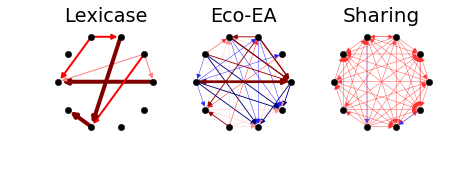

In [822]:
# visualize networks

# lexicase
plt.figure(figsize=(7, 2))
plt.subplot(131)

lex_g = nx.DiGraph()
lex_g = nx.from_dict_of_dicts(lex, create_using=lex_g)

e=[d["weight"] for (u,v,d) in lex_g.edges(data=True)] # colors
widths=[abs(d['weight'])*20 for (u,v,d) in lex_g.edges(data=True)] #linewidths

nx.draw_shell(lex_g, node_color="black", node_size=40, edge_color=e, edge_vmin=global_vmin, edge_vmax=global_vmax,edge_cmap=matplotlib.cm.seismic_r, width=widths, with_labels=False)
plt.title("Lexicase")
plt.subplot(132)

# Eco-EA
eco_g = nx.DiGraph()
eco_g = nx.from_dict_of_dicts(eco, create_using=eco_g)

e=[d["weight"]*4 for (u,v,d) in eco_g.edges(data=True)] # we have to increase color intensity to see lines because
                                                        # lexicase has such stronger interactions
widths=[abs(d['weight'])*20 for (u,v,d) in eco_g.edges(data=True)] # edge widths are consistent across graphs

#e=["red" if d['weight'] < 0 else "blue" for (u,v,d) in eco_g.edges(data=True)]

nx.draw_shell(eco_g, edge_cmap=matplotlib.cm.seismic_r, node_size=40, width=widths, edge_vmin=global_vmin, edge_vmax=global_vmax, node_color="black", edge_color=e, with_labels=False)
plt.title("Eco-EA")

# Fitness sharing
plt.subplot(133)
share_g = nx.DiGraph()
share_g = nx.from_dict_of_dicts(share, create_using=share_g)

e=[d["weight"] * 4 for (u,v,d) in share_g.edges(data=True)]
widths=[abs(d['weight'])*20 for (u,v,d) in share_g.edges(data=True)]

#e=["red" if d['weight'] < 0 else "blue" for (u,v,d) in share_g.edges(data=True)]

nx.draw_shell(share_g, node_size=40, node_color="black", edge_color=e, edge_cmap=matplotlib.cm.seismic_r, edge_vmin=global_vmin, edge_vmax=global_vmax, width=widths, with_labels=False)
plt.title("Sharing", fontsize=20)

plt.savefig("figs/interaction_networks.png", bbox_inches='tight', dpi=300)

# Make other theoretical graphs

- Graphs of long term survival in lexicase
- First stab at R* ZNGI graph, but the consumption vectors aren't quite right

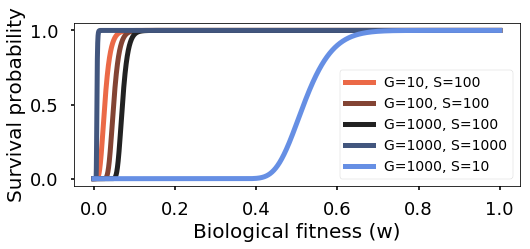

In [831]:
# Master lexicase survival probability graph

# use color scheme that can show two different gradients
pal = sns.diverging_palette(255, 20, l=60, n=5, center="dark")

plt.figure(figsize=(8,3))

matplotlib.style.use("seaborn-poster")
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 

# Calculate curves for parameter sets
xvals = np.arange(0, 1, .0001)
y1 = (1 - (1-xvals)**10)**1000
y2 = (1 - (1-xvals)**100)**1000
y3 = (1 - (1-xvals)**1000)**1000
y4 = (1 - (1-xvals)**100)**10
y5 = (1 - (1-xvals)**100)**100

# Plot curves
plt.plot(xvals, y4, color=pal[4], lw=5, label="G=10, S=100")
plt.plot(xvals, y5, color=pal[3], lw=5, label="G=100, S=100")
plt.plot(xvals, y2, color=pal[2], lw=5, label="G=1000, S=100")
plt.plot(xvals, y3, color=pal[1], lw=5, label="G=1000, S=1000")
plt.plot(xvals, y1, color=pal[0], lw=5, label="G=1000, S=10")

# Axis labels
plt.xlabel("Biological fitness (w)", fontsize=20)
plt.ylabel("Survival probability", fontsize=20)
plt.legend(fontsize=14, loc="best")

plt.savefig('figs/survival.png', bbox_inches='tight', dpi=300)

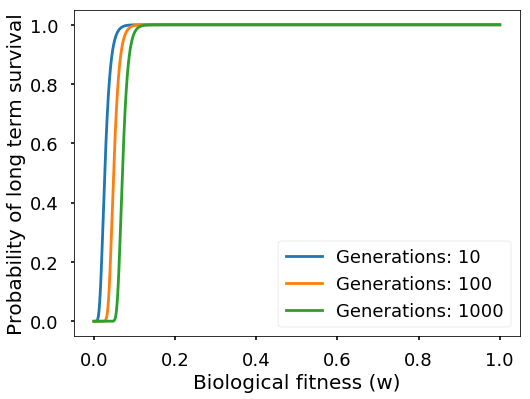

In [826]:
# Stand-alone graph of changing generations

plt.figure(figsize=(8,6))
matplotlib.style.use("seaborn-poster")
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 
xvals = np.arange(0, 1, .0001)
y1 = (1 - (1-xvals)**100)**10
y2 = (1 - (1-xvals)**100)**100
y3 = (1 - (1-xvals)**100)**1000
plt.plot(xvals, y1, label="Generations: 10")
plt.plot(xvals, y2, label="Generations: 100")
plt.plot(xvals, y3, label="Generations: 1000")
plt.xlabel("Biological fitness (w)", fontsize=20)
plt.ylabel("Probability of long term survival", fontsize=20)
plt.legend(fontsize=18)

plt.savefig('figs/survival_generations.png', bbox_inches='tight', dpi=300)

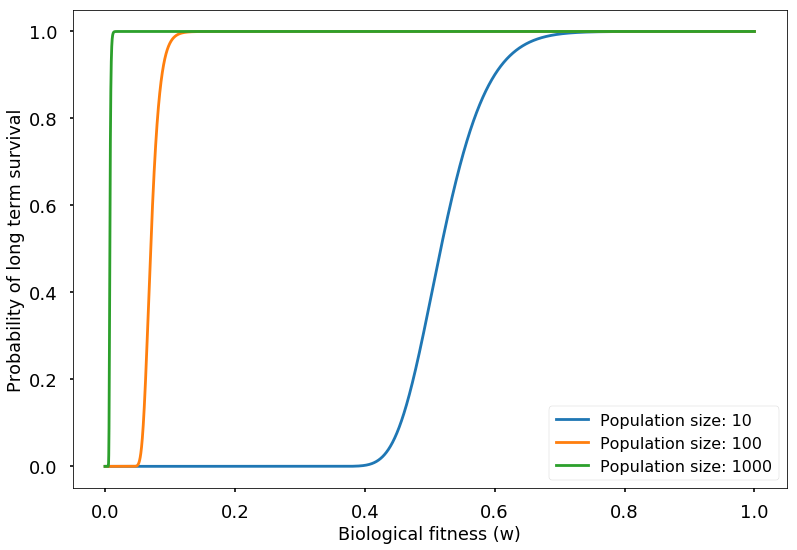

In [827]:
# Standalone graph changing populatzation size

xvals = np.arange(0, 1, .0001)
y1 = (1 - (1-xvals)**10)**1000
y2 = (1 - (1-xvals)**100)**1000
y3 = (1 - (1-xvals)**1000)**1000
plt.plot(xvals, y1, label="Population size: 10")
plt.plot(xvals, y2, label="Population size: 100")
plt.plot(xvals, y3, label="Population size: 1000")
plt.xlabel("Biological fitness (w)")
plt.ylabel("Probability of long term survival")
plt.legend()

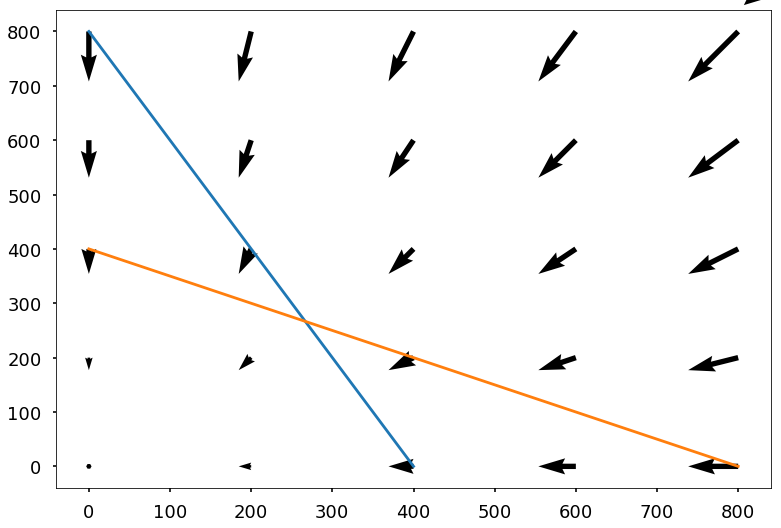

In [832]:
# First stab at ZNGI graph
# Competition for two substitutable resource
# Species are perfect at one task, 50% of maximum at other
# lines are zero net growth isoclines for each species
# arrows are supposed to be consumption vectors but I'm not sure if they're right

X, Y = np.meshgrid(np.arange(0, 1000, 200), np.arange(0, 1000, 200))
U = -.0025*.5*X 
V = -.0025*.5*Y 
plt.plot([0, 400], [800, 0])
plt.plot([0, 800], [400, 0])
Q = plt.quiver(X, Y, U, V, units='width')
qk = plt.quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')

